# Bundle Adjustment

Part of this assignment is based on scipy-cookbook. It will take around 2 hours to finish.

# Question 1: Reading

1. Read the paper 'Building Rome in a Day' and briefly write about the fundamental idea behind the problem and solution. No need to be verbose, just write about the challenge with the task and how the pipeline is implemented (do not include details about performance/parallelization).

2. How is this task different from a SLAM problem?

1. The problem being solved in the paper is of unstructured, uncalibrated, large and fast image matching and 3D reconstruction. They take a large dataset of images of order of magnitude 10e6, possibly from the net search results for an entity such as a city, and match similar images and also reconstruct the 3D map using these matched images without the aid of any additional sensor data such as GPS. Moreover, the images are unstructured, i.e, not in any order and uncalibrated, i.e, taken from different cameras with different calibrations which are unknown. Finally, the above problem is tackled in a fast and efficient manner such that results do not take more than a day to generate. <br />
They use SIFT to extract image features and use nearest-neighbor search to find correspondences between a pair of images using the extracted features. Next, they build a match graph which is a graph with all the images as vertices and edges connecting only similar images, i.e, images that have a minimum number of matching features/correspondences. To build this graph, they repeatedly propose random edges and then verify each of these proposed edges, keeping only the ones where the pair of images satisfy the similarity threshold. The first part is based on whole image similarity where they modeled images as documents where features were mapped to 'visual words' and use the document retrieval system based on TF-IDF scores to retrieve the best/most similar k_1 + k_2 images to the current image under consideration and took only the subset of best k_1 proposed edges for verification. To further improve the graph by reducing the number of connected components, they also verify the edges from the remaining k_2 suggestions where the edge would connect two different connected components in the graph. Finally, the final pass (second part) to enhance the graph involves query expansion where all vertices within a distance of 2 edges are connected by a direct edge and these new set of edges is verified before integrating into the graph. <br />
Next, they generate tracks of features from different images corresponding to the same 3D point. To do this, they make a graph where all the features from all the images are the vertices and the edges connect matching/similar features. The connected components of this graph will correspond to tracks for specific 3D points. Then they took a minimal subset of photographs to remove redundant images to reduce the number of images for faster processing in SFM without the loss of accuracy. Next, they apply custom SFM using bundle adjustment with the LM optimizer to obtain the 3D points and the poses. Finally, they cluster the images and use a multi-view stereo algorithm to improve the estimation of the sparse 3D points obtained from SFM.

2. This is different from SLAM as usually we have structured and even calibrated data in SLAM. At the very least, SLAM makes use of data/images captured from the same sensor/camera and not varying devices whose calibrations are unknown. Additionally, SLAM usually deals with a single smaller entity/environment with a comparatively smaller dataset. Moreover, the data is fairly sparse here compared to SLAM.

# Question 2: Code!

### Task
We have a set of points in real world defined by their coordinates $(X, Y, Z)$ in some apriori chosen "world coordinate frame". We photograph these points by different cameras, which are characterized by their orientation and translation relative to the world coordinate frame and also by focal length and two radial distortion parameters (9 parameters in total). Then we precicely measure 2-D coordinates $(x, y)$ of the points projected by the cameras on images. Our task is to refine 3-D coordinates of original points as well as camera parameters, by minimizing the sum of squares of reprojecting errors.

We will be using a dataset from http://grail.cs.washington.edu/projects/bal/ for this task. Feel free to choose any of the ones mentioned on the page. Take the smallest file from each dataset (you can choose any but it will take longer to run, consume more memory)

In [1]:
import urllib
import copy
import bz2
import os
import numpy as np
import open3d as o3d
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


First download the data file:

In [2]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/"

DATASET_NAME = "final/"
FILE_NAME = "problem-93-61203-pre.txt.bz2"

URL = BASE_URL + DATASET_NAME + FILE_NAME

In [3]:
if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

Now read the data from the file:

In [4]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [5]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

In [6]:
print(f"camera_params: {camera_params.shape};\npoints_3d: {points_3d.shape};\n"
        f"camera_indices: {camera_indices.shape}; \npoint_indices: {point_indices.shape}; \n"
        f"points_2d: {points_2d.shape}")

camera_params: (93, 9);
points_3d: (61203, 3);
camera_indices: (287451,); 
point_indices: (287451,); 
points_2d: (287451, 2)


Here we have numpy arrays:

1. `camera_params` with shape `(n_cameras, 9)` contains initial estimates of parameters for all cameras. First 3 components in each row form a **rotation vector**, next 3 components form a translation vector, then a focal distance and two distortion parameters.
2. `points_3d` with shape `(n_points, 3)` contains initial estimates of point coordinates in the world frame.
3. `points_2d` with shape `(n_observations, 2)` contains measured 2-D coordinates of points projected on images in all the observations.
4. `camera_ind` with shape `(n_observations,)` gives the index of the camera (from 0 to `n_cameras - 1`) associated with a particular observation.   
5. `point_ind` with shape `(n_observations,)` contains indices of 3D points (from 0 to `n_points - 1`) involved in each observation.

# Visualise Point Cloud

Visualise `points_3d`. It may not look like 'Venice' or any building as we are working with a small subset.

In [7]:
def visualizePtCloud(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3d[:, :])

    o3d.visualization.draw_geometries([pcd])

In [8]:
visualizePtCloud(points_3d)

# Extract Parameters

How many cameras and 3D points do we have? Calculate the number of parameters to estimate.

In [9]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]
m = 2 * points_2d.shape[0]
n = n_cameras * camera_params.shape[1] + n_points * 3

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters to estimate: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 93
n_points: 61203
Total number of parameters to estimate: 184446
Total number of residuals: 574902


We chose a relatively small problem to reduce computation time, but scipy's algorithm is capable of solving much larger problems, although required time will grow proportionally.

Now define the function which returns a vector of residuals. We use numpy vectorized computations:

### A short review on Transformations

Rodrigues Formula: $$\mathbf{R}=\cos \theta \mathbf{I}+(1-\cos \theta) \mathbf{n n}^{\mathrm{T}}+\sin \theta \mathbf{n}^{\wedge}$$
If described by a rotation vector, assuming that the rotation axis is a unit length vector $\mathbf{n}$ and the angle is $\theta$, then the vector $\theta \mathbf{n}$ can also describe this rotation. Here, rot_vecs = $\theta \mathbf{n}$.

In [10]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis] #np.newaxis converts this into a column vector.
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    return (cos_theta * points) + ((1 - cos_theta) * v * dot) + (sin_theta * np.cross(v, points))

## A short review on camera modelling & radial distortion



- Each pixel moves radially away from (barrel) or towards (pincushion) the image center (c).
- As a function of distance from $c: r_{c}^{2}=x_{c}^{2}+y_{c}^{2}$.
- The shift $\gamma$ can be modelled as: $\gamma=1+k_{1} r_{c}^{2}+k_{2} r_{c}^{4}$ where ${k}_{1}$ and ${k}_{2}$ are radial distortion parameters.
- The modified co-ordinates are:

$$\begin{array}{l}
\hat{x}_{c}=\gamma x_{c} \\
\hat{y}_{c}=\gamma y_{c}
\end{array} 
$$

- **This is applied before the focal-length multiplier and center shift are applied**: Meaning before $K$ matrix is even applied. But how do we exactly do that?

    $$\mathbf{K}=\left[\begin{array}{ccc}\alpha_{x} & 0 & x_{0} \\0 & \alpha_{y} & y_{0} \\0 & 0 & 1\end{array}\right] ; \qquad      \lambda {p} = \mathrm{x} =K[R \quad t] \mathrm{X}$$

    $$x_{final} = \gamma \left(\frac{f_0X}{Z}+c_x \right)
     \qquad \color{red} \bigotimes \textbf{wrong}$$

    $$x_{final} =  \left(f_0 \left(\gamma\frac{X}{Z} \right)+c_x \right)
     \qquad \color{surd} \checkmark \textbf{correct}$$

### Summing it up
Let $\pmb{P} = (X, Y, Z)^T$ - a radius-vector of a point, $\pmb{R}$ - a rotation matrix of a camera, $\pmb{t}$ - a translation vector of a camera, $f$ - its focal distance, $k_1, k_2$ - its distortion parameters. Then the reprojecting is done as follows:

\begin{align}
\pmb{Q} = \pmb{R} \pmb{P} + \pmb{t} \\
\pmb{q} = -\begin{pmatrix} Q_x / Q_z \\ Q_y / Q_z \end{pmatrix} \\
\pmb{p} = f (1 + k_1 \lVert \pmb{q} \rVert^2 + k_2 \lVert \pmb{q} \rVert^4) \pmb{q}
\end{align}
The resulting vector $\pmb{p}=(x, y)^T$ contains image coordinates of the original point.
![radial_distortion_1.png](./misc/radial_distortion_1.png) 
![radial_distortion_2.png](./misc/radial_distortion_2.png)

In [11]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    
    Q = rotate(points, camera_params[:, :3]) + camera_params[:, 3:6]
    q = -np.vstack([Q[:, 0] / Q[:, 2], Q[:, 1] / Q[:, 2]]).T
    f = np.reshape(camera_params[:, 6], (-1, 1))
    k1 = np.reshape(camera_params[:, 7], (-1, 1))
    k2 = np.reshape(camera_params[:, 8], (-1, 1))
    p = f * (1 + k1 * np.power(q, 2) + k2 * np.power(q, 2)) * q
    return p

In [12]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    params = copy.deepcopy(params)
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

## A short review on Structure from Motion
### Residual
In our lecture, in the residual vector, we  wrote the elements in order: 11, 12, 13.., 1N, then 21, 22.. and so on till MN. However, notice that it is not the case here.

M -> camera, N -> 3D point (in our lectures, NOT in this code)
![sfm_residual_1.png](./misc/sfm_residual_1.png)

You can see that computing Jacobian of `fun` is cumbersome, thus we will rely on the finite difference approximation. To make this process time feasible we provide Jacobian sparsity structure (i. e. mark elements which are known to be non-zero):

![sfm_jac_2.png](./misc/sfm_jac_2.png)

Since the matrix is sparse, we can make use of datastructures that are meant for such a usecase - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html.

In [13]:
from scipy.sparse import lil_matrix

The code for the matrix computation has been given to you, you will have to explain this function later on.

In [48]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = 2 * points_2d.shape[0]
    n = n_cameras * camera_params.shape[1] + n_points * 3
            
    A = lil_matrix((m, n), dtype=int)

    camera_indices = np.sort(camera_indices)
    point_indices = np.sort(point_indices)
    
    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1
            
    return A

### THAT'S IT! Now we are ready to use inbuilt library functions!
Now we are ready to run optimization. Let's visualize residuals evaluated with the initial parameters.

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

In [16]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

In [17]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

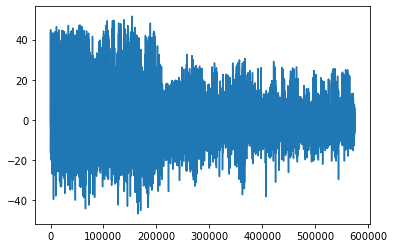

In [18]:
plt.plot(f0)

In [19]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
print(A.shape, n_cameras, n_points)

(574902, 184446) 93 61203


### Optimization

Scipy has existing functions for optimization that we can make use of. Write a sentence about the method that is used for optimization

In [20]:
import time
from scipy.optimize import least_squares

In [21]:
t0 = time.time()
# So far: method='lm'
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-8, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.6469e+06                                    1.69e+07    
       1              3         3.4533e+06      2.19e+06       3.54e+00       3.35e+07    
       2              6         3.4087e+06      4.46e+04       5.49e-01       4.14e+07    
       3              8         3.3266e+06      8.20e+04       1.46e-01       4.33e+07    
       4              9         3.3008e+06      2.58e+04       2.74e-01       4.75e+07    
       5             10         3.2885e+06      1.24e+04       2.77e-01       5.18e+07    
       6             11         3.2866e+06      1.90e+03       7.05e-02       5.28e+07    
       7             12         3.2862e+06      4.05e+02       1.77e-02       5.31e+07    
       8             13         3.2861e+06      9.70e+01       4.43e-03       5.32e+07    
       9             14         3.2860e+06      2.40e+01       1.11e-03       5.32e+07    

In [22]:
params = res.x

new_camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
new_points_3d = params[n_cameras * 9:].reshape((n_points, 3))

### Plot Optimised Points

In [23]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(new_points_3d)
o3d.visualization.draw_geometries([pcd])

Setting `scaling='jac'` was done to automatically scale the variables and equalize their influence on the cost function (clearly the camera parameters and coordinates of the points are very different entities). This option turned out to be crucial for successfull bundle adjustment.

In [24]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 97 seconds


Now let's plot residuals at the found solution:

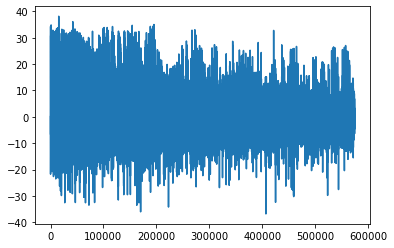

In [25]:
plt.plot(res.fun)

We see much better picture of residuals now, with the mean being very close to zero. There are some spikes left. It can be explained by outliers in the data, or, possibly, the algorithm found a local minimum (very good one though) or didn't converged enough. Note that the algorithm worked with Jacobian finite difference aproximate, which can potentially block the progress near the minimum because of insufficient accuracy (but again, computing exact Jacobian for this problem is quite difficult).

### Project 2- Part B: Submission details -
You are supposed to gain understanding by playing around with the code above and submit your answers to questions asked below. You shouldn't submit this whole notebook, just copy the following cells (starting next cell up until the end of this notebook) and paste it at the end of your Project 2 notebook (already shared on GitHub classrooms, [link](https://github.com/AryanSakaria/Project_2/blob/main/Project_2.ipynb)).

# Theory

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics: When we obtain the observed 2D points, we obtain them for each camera one at a time using some feature detector/extractor such as SIFT. Thus, we simply save the camera indices for the obtained points as and when we obtain points for each camera iteratively.
    
    
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics: Usually we obtain the 3D points estimate using some frontend such as triangulation, etc. from the observed 2D points in each camera frame and the correspondences between the various 2D points in different images. Thus when we obtain the 3D point estimates, we simply note down which 2D points were used to obtain those estimates.
    
3. `0.5 mark` **Transformations** - `rotate()` function: Why do we use the rodriquez formula? How is this representation different from the standard 3x3 Rotation matrix, why do we use this instead?
    - Ans-3 - Transformations: This representation is different from the standard 3x3 rotation matrix in the sense that here the rotation can be applied in a linear way without any convex conditions which are present for the rotation matrix. Additionally, the rotation can be applied as a direct function of the rotation vector. This is done so that we can directly optimize the rotation vector linearly without having to take care of any non-linear conditions. If we were optimizing over the rotation matrix, we could not directly update the rotation matrix using some linear formula involving direct addition, we would have to take the exponential map, etc. and then update. Instead, here we take the rotation vector which can be directly updated using linear operations such as addition, etc.

    
4. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-4 - Transformations: Yes, there would be a difference. When we first translate and then rotate, we are translating in the world frame and rotating the translated vector which would give us a completely different vector from the one we obtain here. Essentially, here we apply the rotation with respect to the original world frame and then the translation with respect to the rotated/camera frame, but when we translate and then rotate, we are translating with respect to the world frame and rotating with respect to the translated/camera frame. Thus, the translation vector would have to be different for the two cases depending on the frame to be able to obtain the same result.
        
        
5. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-5 - Jacobian: This is because we don't have all the 3D points in all the camera frames. In the lecture we assumed that all 3D points are observable from all the camera frames and hence we have the 2D correspondences/image points for all the 3D points in each frame giving us M * N * 2 equations. However, in the practical scenario it is rarely possible that this is the case and usually only some of the N 3D points can be observed in each frame which is the case here as well.
    
6. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 6.1 - Jacobian & Parameters: In the lecture, we made use of the homogeneous transformation matrix of dimensions 3x4 giving us 12 unknowns per camera. This matrix incorporates the intrinsics as well as the extrinsics (rotation + translation) in a single matrix and we simply optimize for this matrix. Here, we have separated the various parameters using different equations for modeling the various parts. We have used 1 equation for the extrinsics which includes 3 rotation parameters and 3 translation parameters and 1 equation for the intrinsics which includes 3 parameters (1 focal length + 2 radial distortion). We have optimized for each of these parameters as separate entities and thus have only 9 unknowns per camera.
        
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 6.2 - Jacobian & Parameters: In the lecture, we had (n_points * 3 + n_cameras * 12) unknowns. Here, in the code, we have (n_cameras * 9 + n_points * 3) unknowns. Here the main difference is in the number of unknowns corresponding to the poses/camera frames. In the lecture we optimized over the projection matrix of dimensions 3x4 to avoid optimizing over the SO(3) manifold and only needed to directly estimate the 12 projection parameters which included both extrinsics and intrinsics in a single matrix. On the other hand, here we model the extrinsics and intrinsics separately using a rotation vector for the rotation (3), a translation vector (3) and 3 additional parameters of focal length (1) and radial distortion (2) making the number of unknowns 9 with regards to each camera frame.
            
            
7. `6 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.) For the toy example, you can take something like 3 points all seen from 3 cameras. (You don't actually have to code much, just need to call the existing function) Write that toy example after this cell
    - Ans 6 - Sparsity, Residual Vector & Jacobian: This code essentially marks the non-zero elements of the sparse Jacobian as 1 for an initialization and leaves the rest as 0. For each of the two rows of each observation/2D image point, the 9 columns of the corresponding camera parameters and the 3 columns of the corresponding 3D point are set to one. The rest of the values/columns are left as 0 as they do not contribute to that observation.
    
    We have learnt that each row in the Jacobian corresponds to an observation/equation while each column corresponds to an unknown parameter which is being optimized. Since each observation/2D point provides 2 equations, 1 for the x and 1 for the y, we have 2 * num_obs rows. As mentioned earlier, we have (n_cameras * 9 + n_points * 3) unknowns and hence this is also the number of columns in the Jacobian. These dimensions are different from the ones used in class due to certain assumptions and method differences as has been explained in earlier questions. 

In [51]:
n_points = 3
n_cameras = 3
points_2d = np.array([np.random.randint(-50, 50, 2)] * n_points * n_cameras)

camera_indices = np.array(list(np.arange(0, n_cameras)) * 3)
point_indices = np.array([0])

for i in range(n_points):
    point_indices = np.hstack([point_indices, [i] * n_cameras])
point_indices = point_indices[1:]

J = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
print("Sparse Jacobian Initialization: \n", J)

Sparse Jacobian Initialization: 
   (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 27)	1
  (0, 28)	1
  (0, 29)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  (1, 6)	1
  (1, 7)	1
  (1, 8)	1
  (1, 27)	1
  (1, 28)	1
  (1, 29)	1
  (2, 0)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	1
  (2, 4)	1
  (2, 5)	1
  (2, 6)	1
  (2, 7)	1
  (2, 8)	1
  (2, 27)	1
  (2, 28)	1
  (2, 29)	1
  (3, 0)	1
  (3, 1)	1
  (3, 2)	1
  (3, 3)	1
  (3, 4)	1
  (3, 5)	1
  (3, 6)	1
  (3, 7)	1
  (3, 8)	1
  (3, 27)	1
  (3, 28)	1
  (3, 29)	1
  (4, 0)	1
  (4, 1)	1
  (4, 2)	1
  (4, 3)	1
  (4, 4)	1
  (4, 5)	1
  (4, 6)	1
  (4, 7)	1
  (4, 8)	1
  (4, 27)	1
  (4, 28)	1
  (4, 29)	1
  (5, 0)	1
  (5, 1)	1
  (5, 2)	1
  (5, 3)	1
  (5, 4)	1
  (5, 5)	1
  (5, 6)	1
  (5, 7)	1
  (5, 8)	1
  (5, 27)	1
  (5, 28)	1
  (5, 29)	1
  (6, 9)	1
  (6, 10)	1
  (6, 11)	1
  (6, 12)	1
  (6, 13)	1
  (6, 14)	1
  (6, 15)	1
  (6, 16)	1
  (6, 17)	1
  (6, 30)	1
  (6, 31)	1
  (6, 32)	1
  (7, 9)	1
  

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers).

We would first extract the correspondences between the two images using some feature extraction and matching algorithm such as SIFT. The functions we would use for this are:

* cv.SIFT_create() :- This function initializes a SIFT object which will contain various parameters and functions that we will need for the actual SIFT steps. We assume the object is assigned to a variable 'sift'.
* sift.detectandCompute() :- It takes an image as input and returns keypoints of interest as well as the descriptors corresponding to each keypoint.
* cv.BFMatcher() :- This function initializes a BF matcher object which will contain various parameters and functions that we will need for the feature matching. We assume the object is assigned to a variable 'bf'.
* bf.knnMatch() :- It takes the two images' feature matrices and k (number of matches per descriptor/point) as input and returns the k best matches for each descriptor in the 1st image's matrix.

If k given to knnMatch() is greater than 1, then we will also have to iterate through each descriptor's match array, compare the various matches and save the best one. Alternatively, we can use other matchers such as cv.FlannBasedMatcher() in place of knnMatch().

Once we have the correspondences, then we must estimate the relative poses. We use epipolar geometry to estimate the Fundamental matrix, F. We use:

* cv.findFundamnetalMatrix() :- This takes the two images correspondences and the algorithm/method as input. We use FM_8POINT or any other method as per convenience for the estimation. It returns the estimated F matrix. Note that we require atleast 8 correspondences to use the FM_8POINT method.

Next, we estimate the essential matrix from F by using the formula $ E = K^T F K $. Then we estimate the rotation and translation from E by decomposing E using:

* cv.decomposeEssentialMat() :- It takes the essential matrix as input and returns the rotation matrix and translation vector obtained by decomposing E.

Thus, we have obtained an estimate for R and t for transforming from the 1st camera to the 2nd. Now we estimate the 3D points using triangulation. We set the projection matrix of the 1st camera as world frame so that R = I and t = 0 and use the estimated R and t for the 2nd camera. For both the project matrix is computed as $ P = K[R | t] $. Finally we apply triangulation as:

* cv.triangulatePoints() :- It takes the 2D correspondences between the 2 cameras and the 2 projection matrices as input. It returns the estimated 3D points in the world frame which in our case is same as the 1st camera's frame.

Thus, we have obtained an estimate for R, t and and 3D points.